In [12]:
# ============================================================
# 0) 依存関係（必要なら一度だけ実行）
# ============================================================
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.preprocessing import StandardScaler

from alibi_detect.cd import MMDDriftOnline


In [ ]:

# ============================================================
# ①の前：N×2 のサンプルデータを「カイ二乗分布」から生成してCSVへ保存
#   - 学習：正常のみ
#   - テスト：正常 → 異常(短め) → 正常 → 異常(長め・異常の仕方を変える)
# ============================================================
rng = np.random.default_rng(0)

def gen_normal(n, df1=6, df2=10, scale2=0.7, noise=0.05):
    x1 = rng.chisquare(df=df1, size=n)
    x2 = rng.chisquare(df=df2, size=n) * scale2
    # 微小ノイズ（同分布でも完全に同じ形にならないように）
    x1 = x1 + rng.normal(0, noise, size=n)
    x2 = x2 + rng.normal(0, noise, size=n)
    return np.c_[x1, x2]

def gen_anom_typeA(n):
    # 短い異常：重い裾（df小） + スケール変更
    x1 = rng.chisquare(df=2, size=n)
    x2 = rng.chisquare(df=10, size=n) * 1.4
    x1 = x1 + rng.normal(0, 0.08, size=n)
    x2 = x2 + rng.normal(0, 0.08, size=n)
    return np.c_[x1, x2]

def gen_anom_typeB(n):
    # 長い異常：平均寄りの変化（df大） + 片方にオフセット + 弱い相関を混ぜる
    x1 = rng.chisquare(df=14, size=n) + 1.2
    base = rng.chisquare(df=3, size=n) * 0.6
    x2 = base + 0.15 * (x1 - x1.mean())  # 相関っぽい成分
    x1 = x1 + rng.normal(0, 0.06, size=n)
    x2 = x2 + rng.normal(0, 0.06, size=n)
    return np.c_[x1, x2]

# サイズ設定
N_train = 1200
seg_n1 = 700     # 正常
seg_a1 = 80      # 異常(短め)
seg_n2 = 520     # 正常
seg_a2 = 500     # 異常(長め)
N_test = seg_n1 + seg_a1 + seg_n2 + seg_a2

X_train = gen_normal(N_train)
X_test  = np.vstack([
    gen_normal(seg_n1),
    gen_anom_typeA(seg_a1),
    gen_normal(seg_n2),
    gen_anom_typeB(seg_a2)
])

# 正解ラベル（評価用）：0=正常, 1=異常
y_test = np.r_[np.zeros(seg_n1), np.ones(seg_a1), np.zeros(seg_n2), np.ones(seg_a2)].astype(int)

df_train_synth = pd.DataFrame(X_train, columns=["f1", "f2"])
df_test_synth  = pd.DataFrame(X_test,  columns=["f1", "f2"])
df_test_synth["is_anom_true"] = y_test  # 後で評価に使う（モデル入力からは除外する）

# CSV保存（区切り文字は任意）
SEP = ";"  # ← ここを "," や "\t" に変えればOK
train_csv_path = ".\\data\\test_5\\test_5_train_synth.csv"
test_csv_path  = ".\\data\\test_5\\test_5_test_synth.csv"
df_train_synth.to_csv(train_csv_path, index=False, sep=SEP)
df_test_synth.to_csv(test_csv_path, index=False, sep=SEP)

print("Saved:", train_csv_path, test_csv_path, " sep=", repr(SEP))


OSError: Cannot save file into a non-existent directory: 'data\test5'

In [ ]:
# ============================================================
# ① データの読み込み（N×M、df形式、学習とテストは別）
# ============================================================
def load_csv_df(path, sep=";", encoding="utf-8"):
    return pd.read_csv(path, sep=sep, encoding=encoding)
SEP = ";"
df_train = load_csv_df(train_csv_path, sep=SEP)
df_test  = load_csv_df(test_csv_path,  sep=SEP)

print("df_train shape:", df_train.shape)
print("df_test  shape:", df_test.shape)


df_train shape: (1200, 2)
df_test  shape: (1800, 3)


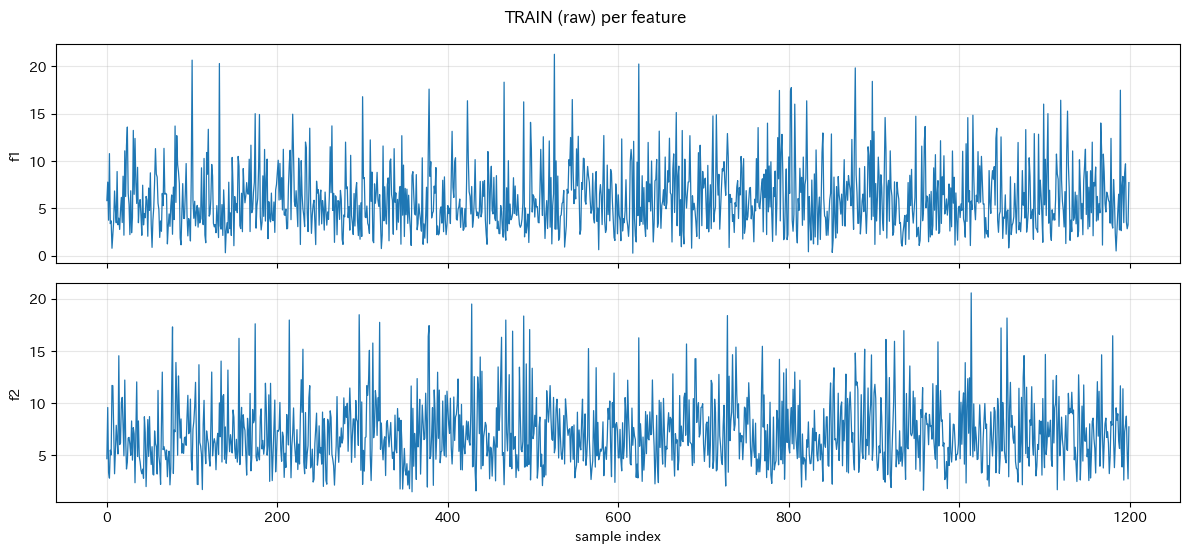

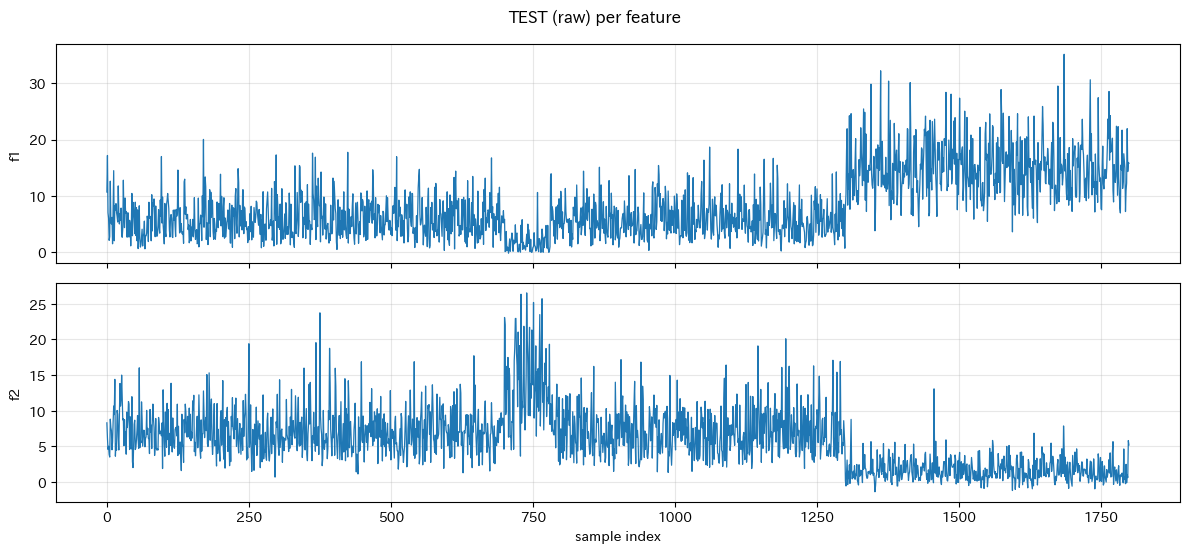

In [ ]:

# ============================================================
# ② 読み込んだあとにデータを可視化（列ごとに時系列波形）
# ============================================================
def plot_timeseries_per_col(df, cols, title):
    n = len(cols)
    fig, axes = plt.subplots(n, 1, figsize=(12, 2.8*n), sharex=True)
    if n == 1:
        axes = [axes]
    x = np.arange(len(df))
    for ax, c in zip(axes, cols):
        ax.plot(x, df[c].values, linewidth=0.9)
        ax.set_ylabel(c)
        ax.grid(True, alpha=0.3)
    axes[-1].set_xlabel("sample index")
    fig.suptitle(title)
    plt.tight_layout()

feature_cols_auto = [c for c in df_train.columns if pd.api.types.is_numeric_dtype(df_train[c])]
# 今回は f1,f2 だけだが、実データでも「数値列だけ自動抽出」→後で選別できる
plot_timeseries_per_col(df_train, feature_cols_auto, "TRAIN (raw) per feature")
plot_timeseries_per_col(df_test,  [c for c in feature_cols_auto if c in df_test.columns], "TEST (raw) per feature")


In [ ]:
# ============================================================
# ③ 前処理
#   - 学習させる列の選択
#   - 標準化（学習データで fit → 学習/テストへ transform）
# ============================================================
# 明示的に選びたい場合はここを書き換え
feature_cols = ["f1", "f2"]

scaler = StandardScaler()
X_train_std = scaler.fit_transform(df_train[feature_cols].values)
X_test_std  = scaler.transform(df_test[feature_cols].values)

# 標準化結果の確認（プリント）
# - 学習データ側：各列の平均≈0、標準偏差≈1 になっているはず（fitしたので）
# - テストデータ側：学習の平均・標準偏差で変換されるので、平均0/分散1になるとは限らない

import numpy as np

print("=== After standardization (TRAIN) ===")
print("shape:", X_train_std.shape)
print("first 5 rows:\n", np.round(X_train_std[:5], 4))
print("mean per feature:", np.round(X_train_std.mean(axis=0), 6))
print("std  per feature:", np.round(X_train_std.std(axis=0, ddof=0), 6))  # ddof=0: StandardScalerと整合

print("\n=== After standardization (TEST) ===")
print("shape:", X_test_std.shape)
print("first 5 rows:\n", np.round(X_test_std[:5], 4))
print("mean per feature (reference=TRAIN stats):", np.round(X_test_std.mean(axis=0), 6))
print("std  per feature (reference=TRAIN stats):", np.round(X_test_std.std(axis=0, ddof=0), 6))

print("\n=== Scaler parameters (fitted on TRAIN) ===")
print("scaler.mean_ :", np.round(scaler.mean_, 6))
print("scaler.scale_:", np.round(scaler.scale_, 6))


=== After standardization (TRAIN) ===
shape: (1200, 2)
first 5 rows:
 [[-0.0594 -0.7558]
 [ 0.5028  0.7702]
 [-0.6573 -1.1649]
 [ 1.371  -1.3363]
 [-0.7614 -0.502 ]]
mean per feature: [-0.  0.]
std  per feature: [1. 1.]

=== After standardization (TEST) ===
shape: (1800, 2)
first 5 rows:
 [[ 1.3513  0.3838]
 [ 3.2225 -0.2827]
 [ 0.29   -0.7743]
 [ 0.0069 -0.6373]
 [-1.1209 -0.9918]]
mean per feature (reference=TRAIN stats): [ 0.660489 -0.352983]
std  per feature (reference=TRAIN stats): [1.65847  1.318454]

=== Scaler parameters (fitted on TRAIN) ===
scaler.mean_ : [6.027938 7.081204]
scaler.scale_: [3.466141 3.216557]


In [ ]:

# ============================================================
# ④ MMDのモデル作成（MMDDriftOnline）
# 
# ============================================================

backend = "tensorflow"
# 参照分布（正常学習データから）
n_ref = 500
x_ref = X_train_std[:n_ref]

# パラメータ（まず動く値）
window_size = 50
ert = 200.0
n_bootstraps = 500  # デモ用に軽め（安定させたいなら増やす）

cd = MMDDriftOnline(
    x_ref=x_ref,
    ert=ert,
    window_size=window_size,
    backend=backend,
    n_bootstraps=n_bootstraps,
    verbose=True
)






Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


[TRAIN check] ratio(test_stat<=threshold)=0.814, false_alarm_rate=0.186


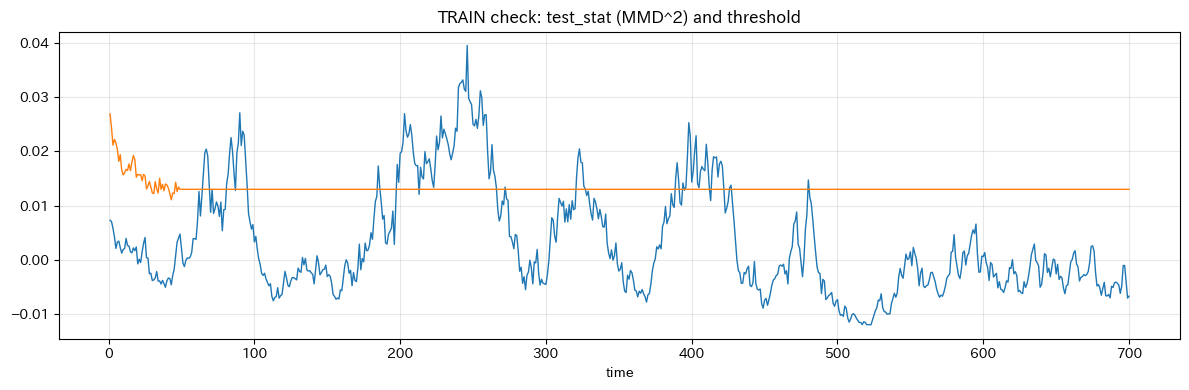

In [ ]:

# ============================================================
# 共通：ストリームを流してログを取る関数
# ============================================================
def run_stream(detector, X_stream):
    records = []
    for t in range(X_stream.shape[0]):
        x_t = X_stream[t]  # (M,) 1サンプル（バッチ次元なし）
        preds = detector.predict(x_t, return_test_stat=True)
        d = preds["data"]
        records.append({
            "time": int(d["time"]),
            "is_drift": int(d["is_drift"]),
            "test_stat": float(d["test_stat"]),
            "threshold": float(d["threshold"])
        })
    return pd.DataFrame(records)

# ============================================================
# ⑤ 学習した結果を、学習データ（正常）で確認
#   - ここでは「参照に使っていない残りの正常」を流す
#   - test_stat <= threshold が多い（=誤検知が少ない）ことを確認
# ============================================================
X_train_holdout = X_train_std[n_ref:]  # 正常のまま
df_log_train = run_stream(cd, X_train_holdout)

ok_ratio = np.mean(df_log_train["test_stat"].values <= df_log_train["threshold"].values)
fa_rate  = np.mean(df_log_train["is_drift"].values == 1)
print(f"[TRAIN check] ratio(test_stat<=threshold)={ok_ratio:.3f}, false_alarm_rate={fa_rate:.3f}")

plt.figure(figsize=(12,4))
plt.plot(df_log_train["time"], df_log_train["test_stat"], linewidth=1.0)
plt.plot(df_log_train["time"], df_log_train["threshold"], linewidth=1.0)
plt.title("TRAIN check: test_stat (MMD^2) and threshold")
plt.xlabel("time")
plt.grid(True, alpha=0.3)
plt.tight_layout()


[TEST] detection_rate(anom)=0.953, false_alarm_rate(norm)=0.116


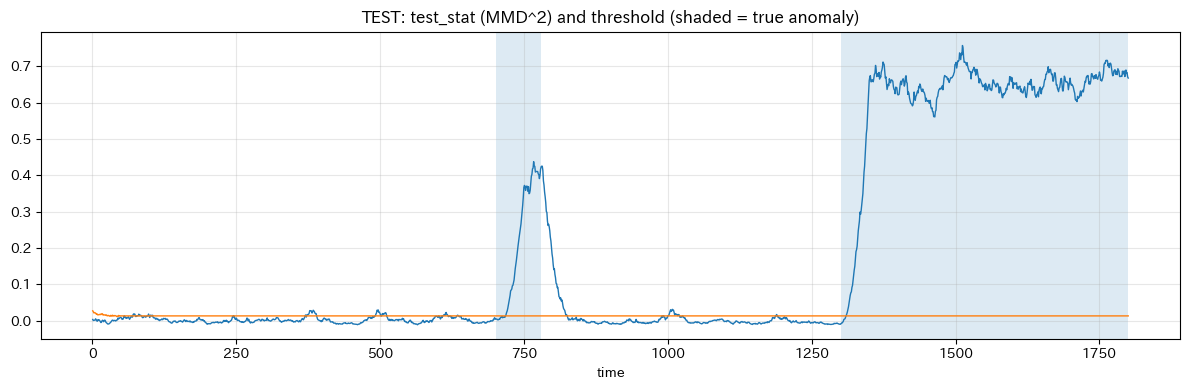

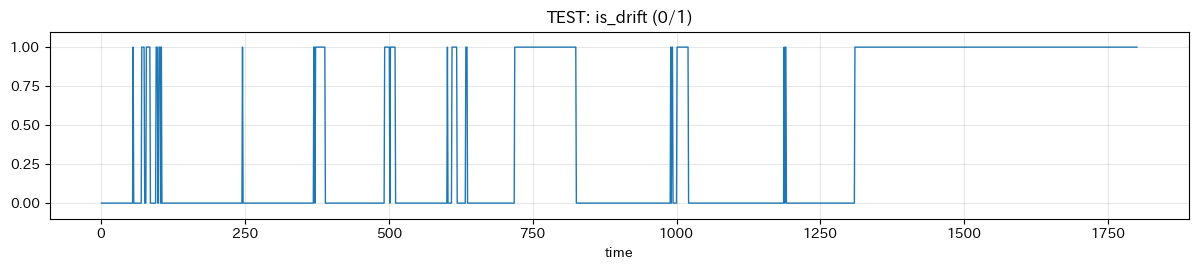

In [ ]:

# ============================================================
# ⑥ テストデータで性能確認
#   - 状態だけリセット（閾値設定は保持）
#   - 正常→異常→正常→異常 の区間で is_drift が立つか見る
# ============================================================
cd.reset_state()

df_log_test = run_stream(cd, X_test_std)

# 真の異常と揃える（time は 1,2,... なので index を合わせる）
y_true = df_test["is_anom_true"].values.astype(int)
y_pred = df_log_test["is_drift"].values.astype(int)

# 区間ごとの簡易集計
def segment_report(y_true, y_pred, name):
    mask = (y_true == 1) if name == "anom" else (y_true == 0)
    if mask.sum() == 0:
        return np.nan
    return y_pred[mask].mean()

det_rate = segment_report(y_true, y_pred, "anom")   # 異常期間に drift=1 が出る割合
fa_rate2 = segment_report(y_true, y_pred, "norm")   # 正常期間に drift=1 が出る割合
print(f"[TEST] detection_rate(anom)={det_rate:.3f}, false_alarm_rate(norm)={fa_rate2:.3f}")

# 可視化：test_stat と threshold、真の異常区間を背景に表示
plt.figure(figsize=(12,4))
plt.plot(df_log_test["time"], df_log_test["test_stat"], linewidth=1.0)
plt.plot(df_log_test["time"], df_log_test["threshold"], linewidth=1.0)
plt.title("TEST: test_stat (MMD^2) and threshold (shaded = true anomaly)")
plt.xlabel("time")
plt.grid(True, alpha=0.3)

# 背景（真の異常区間）
# time は 1 始まりなので、span の左右もそれに合わせる
anom_idx = np.where(y_true == 1)[0]  # 0-based index
if len(anom_idx) > 0:
    # 連続区間に分けて塗る
    starts = [anom_idx[0]]
    ends = []
    for i in range(1, len(anom_idx)):
        if anom_idx[i] != anom_idx[i-1] + 1:
            ends.append(anom_idx[i-1])
            starts.append(anom_idx[i])
    ends.append(anom_idx[-1])
    for s, e in zip(starts, ends):
        # index s..e は time (s+1)..(e+1)
        plt.axvspan(s+1, e+1, alpha=0.15)

plt.tight_layout()

# driftフラグ自体も見たい場合（0/1の時系列）
plt.figure(figsize=(12,2.8))
plt.plot(df_log_test["time"], y_pred, linewidth=1.0)
plt.title("TEST: is_drift (0/1)")
plt.xlabel("time")
plt.ylim(-0.1, 1.1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
